## DrivenData Competition

<b>Team</b>: Adam Fenyvesi, Alban de Raemy, Gustavo A. Trigos, Nicola-Marie Noritz, Yağız Yaver Çiçek

<b>Competition</b>: Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines

<b>Link of Competition</b>: <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/">Click Here</a>

<b>Objective</b>: Your goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. Specifically, you'll be predicting two probabilities: one for h1n1_vaccine and one for seasonal_vaccine.

Each row in the dataset represents one person who responded to the National 2009 H1N1 Flu Survey. 

## Libraries

In [1]:
import time
# Start time including loading the libraries
start = time.time()

In [2]:
# Data exploration and manipulation essentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand

# Statistic tests
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor # Calculating VIF

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Classification Models
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# Cross-validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer  

# Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

# Misc
import gender_guesser.detector as gender

In [9]:
#Setting display options
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',200)
pd.set_option('display.width',500)

In [3]:
# setting random seed
rand.seed(a = 7)

## Loading Data

In [4]:
# Loading the dataset
train_features = pd.read_csv('./datasets/Training_Features.csv',index_col=0)
train_labels = pd.read_csv('./datasets/Training_Labels.csv',index_col=0)

test_features = pd.read_csv('./datasets/Test_Features.csv',index_col=0)

In [5]:
# Joining train and test features
df = pd.concat([train_features,test_features])

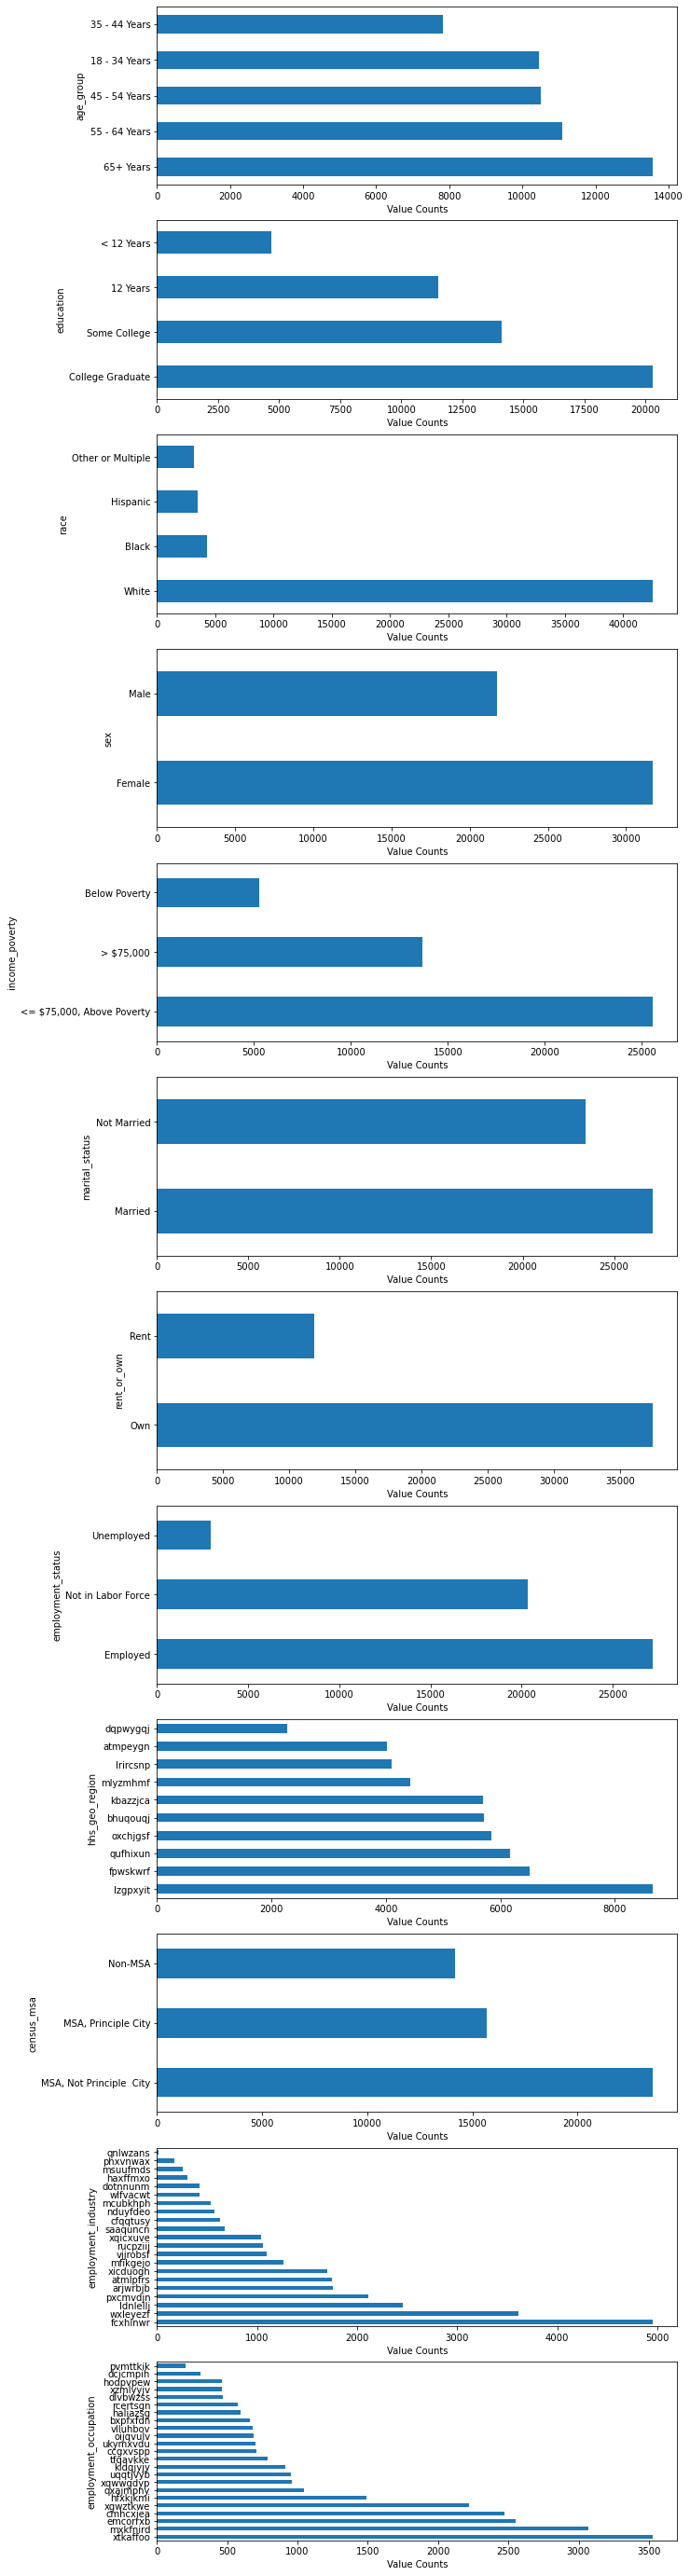

In [10]:
#Marking columns by attributes
cont_columns = [31,32]
interval_columns = [0,1,15,16,17,18,19,20]
categorical_columns = [21,22,23,24,25,26,27,28,29,30,33,34]
logical_columns = [2,3,4,5,6,7,8,9,10,11,12,13,14]

#Inspecting Categorical Variables
fig , ax = fig, ax = plt.subplots(figsize = (10,50 ))
plot_index = 1
for i in categorical_columns:
    plt.subplot(12,1,plot_index)
    plt.ylabel(ylabel = df.columns[i])
    plt.xlabel(xlabel = 'Value Counts')
    temp_df = df.iloc[:,i].value_counts()
    temp_plt = temp_df.plot.barh()
    plot_index += 1
plt.show()

## Data Preprocessing

### Missing Values

In [7]:
# Looking into columns with any missing values
df.isna().mean()[df.isna().sum() > 0] 

h1n1_concern                   0.003314
h1n1_knowledge                 0.004456
behavioral_antiviral_meds      0.002808
behavioral_avoidance           0.007882
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001535
behavioral_large_gatherings    0.002977
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080876
doctor_recc_seasonal           0.080876
chronic_med_condition          0.035627
child_under_6_months           0.030572
health_worker                  0.029823
health_insurance               0.458710
opinion_h1n1_vacc_effective    0.014771
opinion_h1n1_risk              0.014378
opinion_h1n1_sick_from_vacc    0.014415
opinion_seas_vacc_effective    0.017111
opinion_seas_risk              0.018965
opinion_seas_sick_from_vacc    0.019807
education                      0.052682
income_poverty                 0.166994
marital_status                 0.053356
rent_or_own                    0.076346


In [8]:
#Flagging missing cells
for col in train_features:
    if df[col].isna().astype(int).sum() > 0:
        df['m_'+col] = df[col].isna().astype(int)

df.head(n=10)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,m_opinion_seas_sick_from_vacc,m_education,m_income_poverty,m_marital_status,m_rent_or_own,m_employment_status,m_household_adults,m_household_children,m_employment_industry,m_employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,1
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
8,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Data imputation



### Splitting Data into Numerical Data and Categorical

In [21]:
# Select all features excluding 'object' or categorical data
df_num = df.select_dtypes(exclude = 'object').copy()
df_cat = df.select_dtypes(include = 'object').copy()

In [66]:
# Isolating Y-variable from main analysis (choose between h1n1_vaccine or seasonal_vaccine)
response_var_1 = 'h1n1_vaccine'
response_var_2 = 'seasonal_vaccine'
df_response = train_labels

### Exploring Response Variable's proportions

In [67]:
# Response variable proportion breakdown
(df_response[response_var_1].value_counts() / df_response[response_var_1].shape[0]).round(decimals = 2)

0    0.79
1    0.21
Name: h1n1_vaccine, dtype: float64

In [68]:
(df_response[response_var_2].value_counts() / df_response[response_var_2].shape[0]).round(decimals = 2)

0    0.53
1    0.47
Name: seasonal_vaccine, dtype: float64

## Numerical Data

### Correlation with dependent and independent variables

In [69]:
# Correlation between dependent variable and independent variables
response_corr_1 = df_num.join(df_response).corr()[[response_var_1]].sort_values(by=response_var_1,ascending=False).round(decimals=4)
response_corr_2 = df_num.join(df_response).corr()[[response_var_2]].sort_values(by=response_var_2,ascending=False).round(decimals=4)

In [70]:
response_corr_1.join(response_corr_2)

,h1n1_vaccine,seasonal_vaccine
h1n1_vaccine,1.0000,0.3771
doctor_recc_h1n1,0.3939,0.1986
seasonal_vaccine,0.3771,1.0000
opinion_h1n1_risk,0.3233,0.2166
opinion_h1n1_vacc_effective,0.2693,0.2051
opinion_seas_risk,0.2586,0.3901
doctor_recc_seasonal,0.2099,0.3692
opinion_seas_vacc_effective,0.1793,0.3619
health_worker,0.1698,0.1273
h1n1_concern,0.1219,0.1548


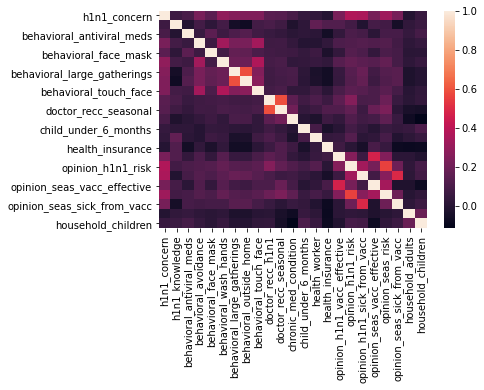

In [71]:
# Correlation Matrix Heatmap
sns.heatmap(df_num.corr())

### Transformation and Normalization

In [81]:
# # Transform data to log transform
# log_cols = df_num.columns 

# # Creating new columns with new log prefix and natural logarithm transformation.
# for col in log_cols:
#     # Adding constant 1 to avoid transforming log of zero
#     df_num.loc[:,'log_'+col] = np.log(df_num[col]+1)

In [82]:
# # Dropping original values after being transformed
# df_num.drop(log_cols,axis=1,inplace=True)

In [22]:
# Normalize data with Min-Max Scaler with a range of 0 to 1
df_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_num))
df_norm.set_index(df_num.index, inplace = True)

## Categorical Data

In [23]:
# Subsetting observations from numerical data 
df_cat = df_cat.loc[df_norm.index]

In [19]:
# Looking into columns with any missing values
df.iloc[:,categorical_columns].isna().mean()[df.isna().mean() > 0.1] 

Series([], dtype: float64)

In [24]:
#Marking significant unknown cells
df_cat['income_poverty'] = df_cat['income_poverty'].fillna('unknown')
df_cat['employment_industry'] = df_cat['employment_industry'].fillna('unknown')
df_cat['employment_occupation'] =  df_cat['employment_occupation'].fillna('unknown')

In [26]:
df_cat.fillna(df_cat.mode(), inplace= True)

df_cat.head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,unknown,unknown
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",unknown,unknown
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb


In [27]:
df_cat.isna().sum()

age_group                   0
education                2814
race                        0
sex                         0
income_poverty              0
marital_status           2850
rent_or_own              4078
employment_status        2934
hhs_geo_region              0
census_msa                  0
employment_industry         0
employment_occupation       0
dtype: int64

## Feature Engineering

In [87]:
# Joining number data with categorical data, then separating features from the target value.
df_features = df_cat.join(df_norm)

### Domain Knowledge Features

In [88]:
# Making sure inf values turn into nan
df_features.replace([np.inf, -np.inf], np.nan,inplace=True)
df_features.fillna(0,inplace=True)

### Interactions

In [89]:
# Create every possible bivariate combination to be tested for feature engineering
from itertools import combinations

interaction_list = df_num.columns

interactions = list(combinations(interaction_list, 2))

In [90]:
# Iterate through interaction list to perform linear regression for each possible engineered features
for interaction in interactions:
    df_features['{}_{}'.format(interaction[0],interaction[1])] = df_features[interaction[0]] * df_features[interaction[1]]

df_features.shape

(53415, 288)

## Train-Test Split

In [95]:
# Dividing dataset into dependent and independent variables
X = df_features
y1 = df_response[response_var_1]
y2 = df_response[response_var_2]

### Split

In [58]:
# Splitting the dataset into 75% Trainning and 25% Testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size = 0.25, 
#                                                     random_state = 219, 
#                                                     stratify=y)

In [96]:
X_train = X.loc[train_features.index]
X_test = X.loc[test_features.index]
y1_train = y1
y2_train = y2

## Predictive Model Development

In [59]:
# Defining a function to output metrics

def metrics(model,X,y,X_train,y_train,X_test,y_test):
    
    # FITTING on the whole data (tuned models went through Cross-Validation with the whole data)
    model_fit = model.fit(X,y)
    
    # PREDICTING on new data
    model_pred = model_fit.predict(X_test)

    # saving scoring data for future use
    model_train_score = model.score(X_train,y_train).round(decimals = 4)
    model_test_score  = model.score(X_test,y_test).round(decimals = 4)
    
    # ROC-AUC score  (test score)
    auc_score = roc_auc_score(y_test,model_pred).round(decimals = 4)
    
    # unpacking the confusion matrix
    model_tn, model_fp, model_fn, model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()
    
    # Confusion Matrix
    c_matrix = (model_tn, model_fp, model_fn, model_tp)
    
    return model_train_score, model_test_score, auc_score, c_matrix
    

In [60]:
def plot_feature_importances(model, X_train, top_features=10):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    top_features : number of top features to show
    
    """
    
    # Getting features and their relative importance according to the model
    features = X_train.columns
    feature_importance = model.feature_importances_

    # Creating dataframe 
    feature_importance_df = pd.DataFrame(data={'Feature Importance': feature_importance},index=features)
    
    # Sorted and top features
    sorted_df = feature_importance_df.sort_values(by='Feature Importance', ascending=False).head(top_features)

    # Plotting the result
    sorted_df.plot.barh()
    plt.xlabel("Feature importance (%)")
    

### Logistic Regression

In [62]:
# Instantiating OLS Linear Regression model
logistic_regression = LogisticRegression()

In [63]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# penalty_space          = ['l1', 'l2','elasticnet']
# tol_space = np.arange(0.0001, 1, 0.005)
# C_space  = np.arange(0.1, 5, 0.1)
# class_weight_space = ['balanced',None]
# solver_space     = ['newton-cg', 'sag', 'lbfgs','saga']
# multi_class_space = ['auto', 'ovr', 'multinomial']
# warm_start_space = [True, False]

# # creating a hyperparameter grid
# param_grid = {'penalty' : penalty_space,
#                 'tol'   : tol_space,
#                 'C'          : C_space ,
#                 'class_weight' : class_weight_space,
#                 'solver'     : solver_space,
#                 'multi_class'     : multi_class_space,
#                 'warm_start'     : warm_start_space}


# # INSTANTIATING the model object without hyperparameters
# logistic_tuned = logistic_regression



# # RandomizedSearchCV object
# logistic_tuned_cv = RandomizedSearchCV(estimator           = logistic_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# logistic_tuned_cv.fit(X, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", logistic_tuned_cv.best_params_)
# print("Tuned CV AUC      :", logistic_tuned_cv.best_score_.round(4))


In [64]:
# Storing tuned parameters in dictionary
logistic_params = {'warm_start': False, 'tol': 0.8101, 'solver': 'newton-cg', 
                   'penalty': 'l2', 'multi_class': 'auto', 
                   'class_weight': 'balanced', 'C': 0.8}

# Setting tuned parameters
logistic_regression = logistic_regression.set_params(**logistic_params)

In [65]:
# logistic_regression = logistic_tuned_cv.best_estimator_

### K-Nearest Neighbors Classification (KNN)

In [66]:
# Instantiating KNN model
knn_classifier = KNeighborsClassifier()

In [67]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# n_neighbors_space          = np.arange(15,25,1)
# weights_space = ['uniform','distance']
# algorithm_space          = ['auto','ball_tree','kd_tree','brute']
# leaf_size_space = np.arange(15,30,5)
# p_space = [1,2]

# # creating a hyperparameter grid
# param_grid = {'n_neighbors' : n_neighbors_space,
#               'weights'   : weights_space,
#                 'algorithm' : algorithm_space ,
#               'leaf_size': leaf_size_space,
#               'p' : p_space
#              }


# # INSTANTIATING the model object without hyperparameters
# knn_tuned = knn_classifier



# # RandomizedSearchCV object
# knn_tuned_cv = RandomizedSearchCV(estimator           = knn_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# knn_tuned_cv.fit(X, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", knn_tuned_cv.best_params_)
# print("Tuned CV AUC      :", knn_tuned_cv.best_score_.round(4))


In [68]:
# Storing tuned parameters in dictionary
knn_params = {'weights': 'uniform', 'p': 2, 'n_neighbors': 16, 
              'leaf_size': 15, 'algorithm': 'kd_tree'}

# Setting tuned parameters
knn_classifier = knn_classifier.set_params(**knn_params)

In [69]:
# knn_classifier = knn_tuned_cv.best_estimator_

### Classification Tree 

In [70]:
# Instantiating classification tree model
tree_classifier = DecisionTreeClassifier()

In [71]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# criterion_space          = ['gini', 'entropy']
# splitter_space = ['best','random']
# max_depth_space          = np.arange(2, 6, 1)
# min_samples_leaf_space = np.arange(5, 15, 1)
# min_samples_split_space = np.arange(2, 4, 1)
# max_features_space     = ['auto', 'sqrt', 'log2']


# # creating a hyperparameter grid
# param_grid = {'criterion' : criterion_space,
#               'splitter'   : splitter_space,
#                 'max_depth'          : max_depth_space ,
#               'min_samples_leaf' : min_samples_leaf_space,
#               'min_samples_split'     : min_samples_split_space,
#                'max_features'     : max_features_space}


# # INSTANTIATING the model object without hyperparameters
# tree_tuned = tree_classifier



# # RandomizedSearchCV object
# tree_tuned_cv = RandomizedSearchCV(estimator           = tree_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# tree_tuned_cv.fit(X, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tree_tuned_cv.best_params_)
# print("Tuned CV AUC      :", tree_tuned_cv.best_score_.round(4))


In [72]:
# Storing tuned parameters in dictionary
tree_params = {'splitter': 'best', 'min_samples_split': 3, 'min_samples_leaf': 6, 
               'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini'}

# Setting tuned parameters
tree_classifier = tree_classifier.set_params(**tree_params)

In [73]:
# tree_classifier = tree_tuned_cv.best_estimator_

### Random Forest

In [74]:
# Instantiating Random Forest model
random_forest = RandomForestClassifier(max_depth=8)

In [75]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# n_estimators_space          = np.arange(50, 150, 10)
# max_depth_space  = np.arange(4, 8, 1)
# min_samples_split_space  = np.arange(6, 10, 2)
# min_samples_leaf_space  = np.arange(24, 30, 2)
# max_features_space = ["auto", "sqrt", "log2"]
# max_leaf_nodes_space = np.arange(40, 80, 10)
# class_weight_space = ['balanced','balanced_subsample']


# # creating a hyperparameter grid
# param_grid = {'n_estimators' : n_estimators_space,
#                 'max_depth'          : max_depth_space ,
#                 'min_samples_split' : min_samples_split_space,
#                 'min_samples_leaf'     : min_samples_leaf_space,
#                 'max_features'     : max_features_space,
#                 'max_leaf_nodes'     : max_leaf_nodes_space,
#                 'class_weight'     : class_weight_space}


# # INSTANTIATING the model object without hyperparameters
# forest_tuned = random_forest



# # RandomizedSearchCV object
# forest_tuned_cv = RandomizedSearchCV(estimator           = forest_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# forest_tuned_cv.fit(X, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", forest_tuned_cv.best_params_)
# print("Tuned CV AUC      :", forest_tuned_cv.best_score_.round(4))


In [76]:
# Storing tuned parameters in dictionary
forest_params = {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 26, 
                 'max_leaf_nodes': 40, 'max_features': 'auto', 'max_depth': 7, 
                 'class_weight': 'balanced'}

# Setting tuned parameters
random_forest = random_forest.set_params(**forest_params)

In [77]:
# random_forest = forest_tuned_cv.best_estimator_

### Gradient Boosted Models (GBM)

In [78]:
# Instantiating GBM
gradient_boosting = GradientBoostingClassifier(max_depth=8)

In [79]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# n_estimators_space          = np.arange(50, 200, 20)
# max_depth_space  = np.arange(3, 8, 1)
# max_leaf_nodes_space = np.arange(10, 30, 2)


# # creating a hyperparameter grid
# param_grid = {
#                 'n_estimators'          : n_estimators_space ,
#                 'max_depth'     : max_depth_space,
#              'max_leaf_nodes'     : max_leaf_nodes_space}


# # INSTANTIATING the model object without hyperparameters
# boost_tuned = gradient_boosting



# # RandomizedSearchCV object
# boost_tuned_cv = RandomizedSearchCV(estimator           = boost_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# boost_tuned_cv.fit(X, y)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", boost_tuned_cv.best_params_)
# print("Tuned CV AUC      :", boost_tuned_cv.best_score_.round(4))


In [80]:
# Storing tuned parameters in dictionary
boost_params = {'n_estimators': 70, 'max_leaf_nodes': 12, 'max_depth': 4}

# Setting tuned parameters
gradient_boosting = gradient_boosting.set_params(**boost_params)

In [81]:
# gradient_boosting = boost_tuned_cv.best_estimator_

In [82]:
# # Plotting relative feature importance sa
# plot_feature_importances(gradient_boosting, X_train, 15)

## Model Performance Comparison

In [83]:
# Runnign function gather score of models
logistic_train_score, logistic_test_score, logistic_auc_score, logistic_c_matrix = metrics(logistic_regression,X,y,X_train,y_train,X_test,y_test)
knn_train_score, knn_test_score, knn_auc_score, knn_c_matrix = metrics(knn_classifier,X,y,X_train,y_train,X_test,y_test)
tree_train_score, tree_test_score, tree_auc_score, tree_c_matrix  = metrics(tree_classifier,X,y,X_train,y_train,X_test,y_test)
random_train_score, random_test_score, random_auc_score, random_c_matrix  = metrics(random_forest,X,y,X_train,y_train,X_test,y_test)
gradient_train_score, gradient_test_score, gradient_auc_score, gradient_c_matrix  = metrics(gradient_boosting,X,y,X_train,y_train,X_test,y_test)

In [84]:
# creating a dictionary to store model results
model_performance = {
    
    'Model Type'    : ['Logistic Regression', 'KNN','Decision Tree', 'Random Forest', 'GBM (Final Model)'],
           
    
    'AUC Score'  : [logistic_auc_score,
                    knn_auc_score, tree_auc_score,random_auc_score,gradient_auc_score],
    
    'Training Accuracy' : [logistic_train_score,
                        knn_train_score, tree_train_score,random_train_score,gradient_train_score],
           
    'Testing Accuracy'  : [logistic_test_score,
                        knn_test_score, tree_test_score,random_test_score,gradient_test_score],
    
    'Confusion Matrix' : [logistic_c_matrix, knn_c_matrix, tree_c_matrix, random_c_matrix, gradient_c_matrix]

}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)
model_performance

,Model Type,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic Regression,0.7202,0.7231,0.7187,"(113, 43, 94, 237)"
1,KNN,0.6293,0.7313,0.7310,"(54, 102, 29, 302)"
2,Decision Tree,0.5192,0.6765,0.6920,"(6, 150, 0, 331)"
3,Random Forest,0.7834,0.7903,0.8070,"(112, 44, 50, 281)"
4,GBM (Final Model),0.8503,0.8794,0.8932,"(114, 42, 10, 321)"


In [85]:
# Number of Seconds to run the script
end = time.time()
print("Time in Seconds:", round(end - start,2))

Time in Seconds: 15.46
